# Гарапко Даниил, группа 858641

# Лабораторная работа №9 “Рекомендательные системы”

In [0]:
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from scipy import optimize, sparse
from scipy.io import loadmat
from scipy.spatial import distance
import scipy.cluster.hierarchy as shc
import scipy.stats as sts
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.utils import shuffle
from sklearn.decomposition import TruncatedSVD
import numpy as np
import pandas as pd
import random
from PIL import Image

## Task 1

Набор данных ex9_movies.mat представляет собой файл формата *.mat
(т.е. сохраненного из Matlab). Набор содержит две матрицы Y и R - рейтинг
1682 фильмов среди 943 пользователей. Значение R<sub>ij</sub> может быть равно 0 или
1 в зависимости от того оценил ли пользователь j фильм i. Матрица Y
содержит числа от 1 до 5 - оценки в баллах пользователей, выставленные
фильмам.

1. Загрузите данные ex9_movies.mat из файла.

In [0]:
task1_file_name = "Data\Lab 9\ex9_movies.mat"
mat = loadmat(task1_file_name)  # load mat-file
Y = mat['Y']
R = mat['R']

In [0]:
n_m, n_u = Y.shape

2. Выберите число признаков фильмов (n) для реализации алгоритма
коллаборативной фильтрации

In [0]:
n = 30
lmbda = 1.0
X = np.random.rand(n, n_m)
# X = np.hstack((np.ones((n_m,1)), X.T)).T
theta = np.random.rand(n_u, n)

3. Реализуйте функцию стоимости для алгоритма.


In [0]:
lost_func = lambda t,x,y,r : (1.0 / 2.0) * (np.sum(r*np.square(np.dot(t, x).T - y)) 
                                            + lmbda * np.sum(np.square(t))
                                            + lmbda * np.sum(np.square(X)))

4. Реализуйте функцию вычисления градиентов.

In [0]:
grad_func_theta = lambda t,x,y,r: np.dot((r * (np.dot(t, x).T - y)).T, x.T) + lmbda * t
grad_func_x = lambda t,x,y,r: np.dot((r * (np.dot(t, x).T - y)), t).T + lmbda * x

5. При реализации используйте векторизацию для ускорения процесса
обучения.

6. Добавьте L2-регуляризацию в модель.

7. Обучите модель с помощью градиентного спуска или других методов
оптимизации.

In [0]:
def optimize_by_gradient_descent(x, y, t, r, learning_rate=1e-4, iterations=100):
    costs = []
    delta = -1
    step = 1
    for i in range(iterations):
        #theta part
        temp = t - learning_rate * grad_func_theta(t, x, y, r)
        cost = lost_func(temp, x, y, r).item()
        if costs:
            delta = cost - costs[-1]
        costs.append(cost)
        step += 1
        if delta > 0:
            break
        t = temp
        #x part
        temp = x - learning_rate * grad_func_x(t, x, y, r)
        cost = lost_func(t, temp, y, r).item()
        if costs:
            delta = cost - costs[-1]
        costs.append(cost)
        step += 1
        if delta > 0:
            break
        x = temp
    plt.plot(np.array([range(1, step)]).T, costs)
    plt.show()
    return t,x

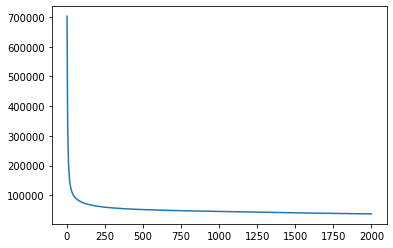

In [0]:
theta, X = optimize_by_gradient_descent(X, Y, theta, R, learning_rate=1e-4, iterations=1000)

8. Добавьте несколько оценок фильмов от себя. Файл movie_ids.txt
содержит индексы каждого из фильмов.

69 Forrest Gump (1994)<br/>
71 Lion King, The (1994)<br/>
95 Aladdin (1992)<br/>
107 Moll Flanders (1996)<br/>
127 Godfather, The (1972)<br/>
752 Replacement Killers, The (1998)<br/>
856 Night on Earth (1991)<br/>
902 Big Lebowski, The (1998)<br/>
918 City of Angels (1998)<br/>

In [0]:
my_marks = [(69,5),(71,4),(95,3),(107,2),(127,4),(752,5),(856,3),(902,5),(918,4)]

In [0]:
R = np.insert(R, n_u, values=0, axis=1)
Y = np.insert(Y, n_u, values=0, axis=1)
for pos,mark in my_marks:
    R[pos-1,-1] = 1
    Y[pos-1,-1] = mark
theta = np.insert(theta, n_u, values=np.random.rand(1, n), axis=0)

9. Сделайте рекомендации для себя. Совпали ли они с реальностью?

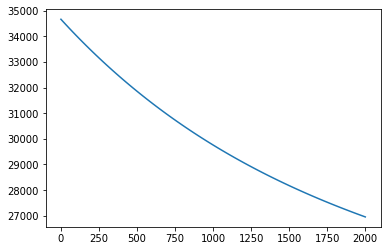

In [0]:
theta, X = optimize_by_gradient_descent(X, Y, theta, R, learning_rate=1e-4, iterations=1000)

In [0]:
X_sparse = sparse.csr_matrix(X)
similarities_sparse = cosine_similarity(X_sparse.T,dense_output=False)
most_common_films = set()
for pos,mark in my_marks:
    if mark < 4:
        continue
    common_films = np.where(similarities_sparse[pos-1].toarray()>0.87)[1]
    most_common_films.update(common_films)

In [0]:
most_common_films

{0, 68, 70, 94, 126, 186, 392, 751, 901, 917, 1225}

10.Также обучите модель с помощью сингулярного разложения матриц.
Отличаются ли полученные результаты?

In [0]:
svd = TruncatedSVD(n_components=n)
svd.fit(X)

TruncatedSVD(algorithm='randomized', n_components=30, n_iter=5,
             random_state=None, tol=0.0)

In [0]:
svd.singular_values_

array([86.82600791, 13.34467162, 12.23363681, 12.10434018, 11.99932542,
       11.85625231, 11.76438073, 11.65126545, 11.55817203, 11.45319997,
       11.35490574, 11.28148474, 11.2648102 , 11.22911559, 11.07030473,
       10.96494622, 10.89647377, 10.79791731, 10.76574243, 10.70693184,
       10.62190851, 10.54700166, 10.52782613, 10.41932558, 10.35727928])

In [0]:
svd.explained_variance_ratio_.cumsum()

array([7.78240132e-04, 5.07137653e-02, 9.26821354e-02, 1.33767675e-01,
       1.74143789e-01, 2.13562724e-01, 2.52373229e-01, 2.90440598e-01,
       3.27902466e-01, 3.64686867e-01, 4.00842642e-01, 4.36532170e-01,
       4.72116128e-01, 5.07474922e-01, 5.41840992e-01, 5.75555658e-01,
       6.08850963e-01, 6.41545337e-01, 6.74046405e-01, 7.06193437e-01,
       7.37831753e-01, 7.69024197e-01, 8.00104445e-01, 8.30545380e-01,
       8.60627091e-01, 8.89928610e-01, 9.18866037e-01, 9.46670682e-01,
       9.73821548e-01, 1.00000000e+00])

Убираем 5 признаков и считаем новое X

In [0]:
svd = TruncatedSVD(n_components=n-5)
svd.fit(X)

TruncatedSVD(algorithm='randomized', n_components=25, n_iter=5,
             random_state=None, tol=0.0)

In [0]:
U = svd.transform(X) / svd.singular_values_
Sigma = svd.singular_values_
VT = svd.components_

X ≈ X' = UΣV*

In [0]:
X_new = np.dot(U.dot(np.diag(Sigma)), VT)

U - есть тета

In [0]:
Y_new = R * (np.dot(theta, X_new).T)

In [0]:
np.nonzero(Y_new[:,-1])

(array([ 68,  70,  94, 106, 126, 751, 855, 901, 917], dtype=int64),)

In [0]:
X_sparse = sparse.csr_matrix(X_new)
similarities_sparse = cosine_similarity(X_sparse.T,dense_output=False)
most_common_films = set()
for pos,mark in my_marks:
    if mark < 4:
        continue
    common_films = np.where(similarities_sparse[pos-1].toarray()>0.87)[1]
    most_common_films.update(common_films)

In [0]:
most_common_films

{0,
 3,
 11,
 14,
 27,
 54,
 63,
 68,
 70,
 94,
 126,
 149,
 153,
 179,
 186,
 187,
 190,
 192,
 196,
 212,
 301,
 316,
 317,
 356,
 384,
 392,
 417,
 419,
 426,
 473,
 482,
 484,
 494,
 510,
 519,
 526,
 528,
 649,
 670,
 707,
 751,
 791,
 810,
 846,
 881,
 901,
 916,
 917,
 935,
 1074,
 1107,
 1197,
 1225,
 1357,
 1360,
 1363,
 1365,
 1367,
 1448,
 1460,
 1464,
 1499,
 1540,
 1545,
 1565,
 1598,
 1608,
 1637,
 1646,
 1669,
 1676}